In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import models

In [2]:
# ckpt_dir = "checkpoint/wage/lr8lr2_210_testrun-seed-100"
ckpt_dir = "checkpoint/wage/lr8lr2_210_rerun-seed-100"
epoch = 299
data = torch.load(os.path.join(ckpt_dir, "checkpoint-%d.pt"%epoch))
data.keys()

dict_keys(['epoch', 'acc_dict', 'swa_n', 'full_tern', 'low_tern', 'low_acc'])

features.1.weight


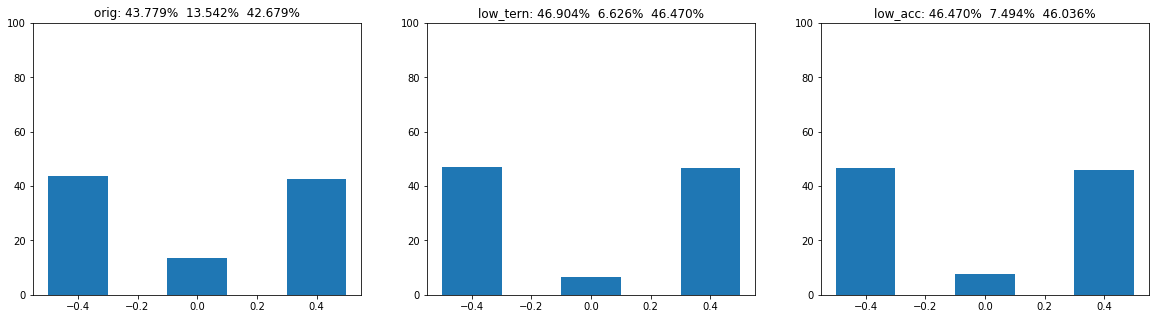

features.4.weight


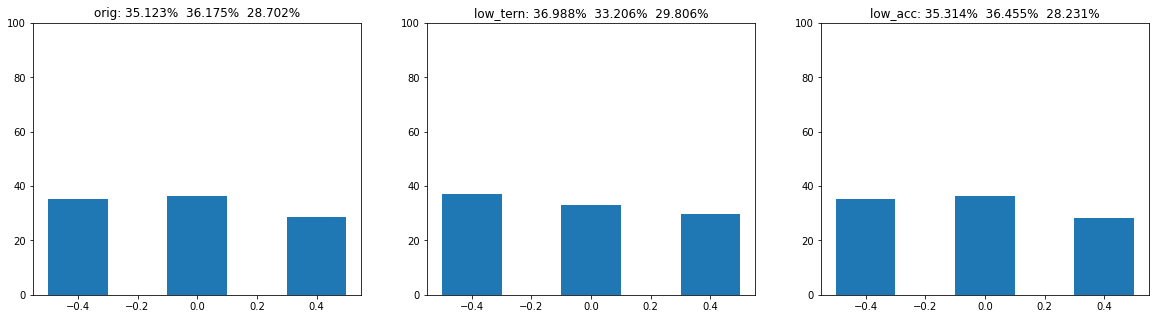

features.8.weight


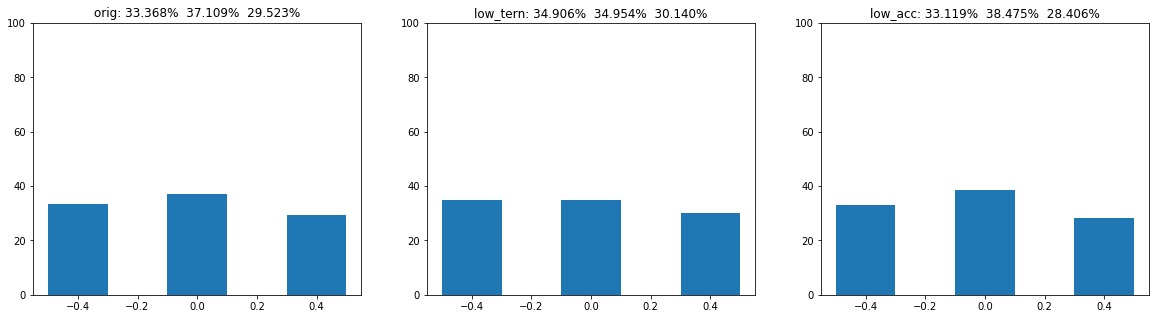

features.11.weight


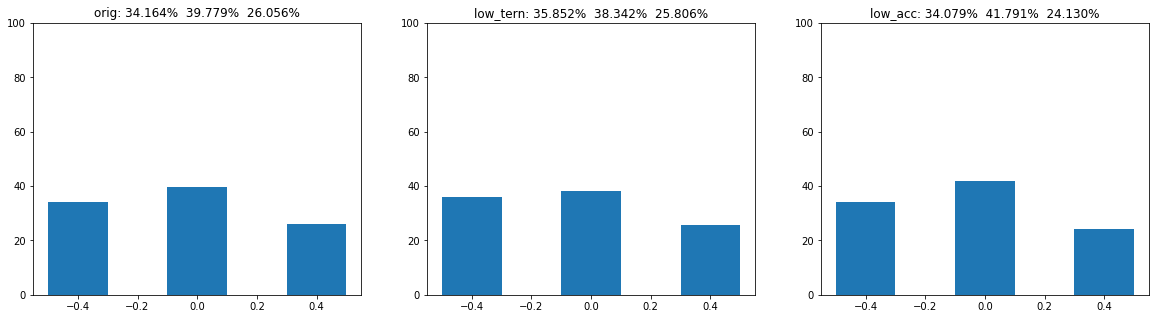

features.15.weight


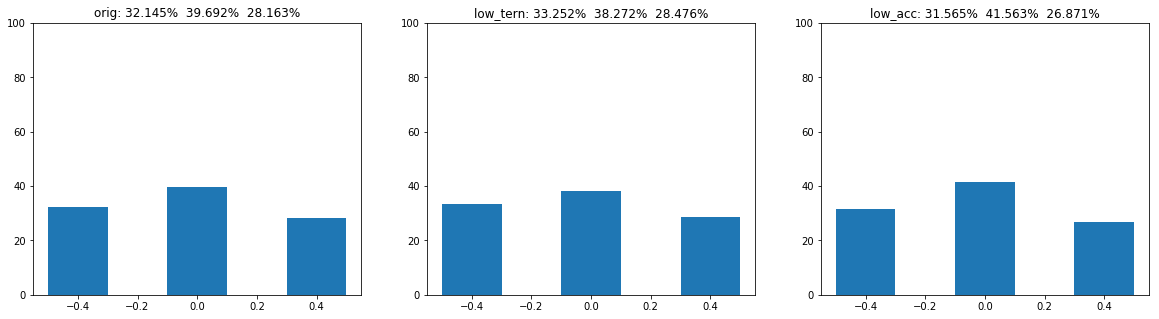

features.18.weight


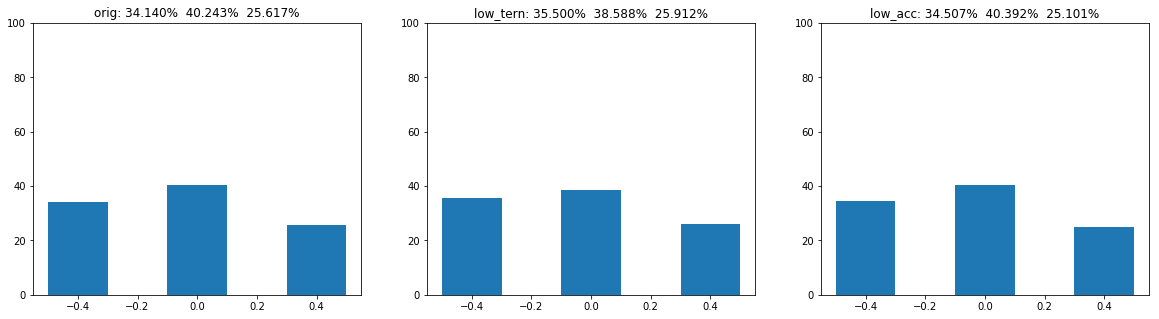

classifier.0.weight


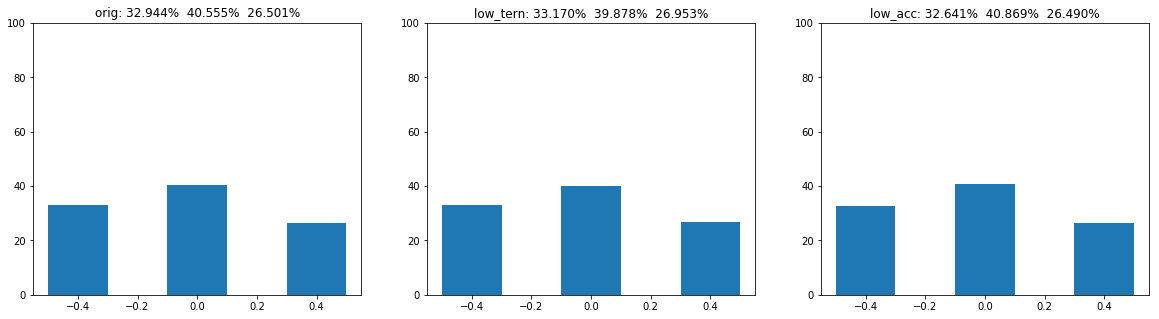

classifier.3.weight


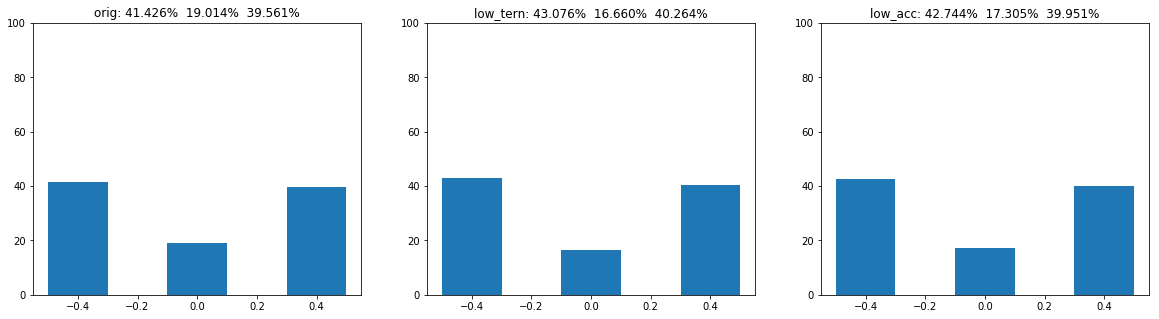

In [3]:
wl = 2
full_tern = {k:models.QW(v, wl).cpu().numpy() for k,v in data['full_tern'].items()}
low_tern = {k:models.QW(v, wl).cpu().numpy() for k,v in data['low_tern'].items()}
low_acc = {k:models.QW(v, wl).cpu().numpy() for k,v in data['low_acc'].items()}
orig = {k:models.QW(v, wl).cpu().numpy() for k,v in data['acc_dict'].items()}
layer_keys = orig.keys()
layer_keys, orig['features.1.weight'].shape

def plot_hist(k, thrs=[0., 0., 0.]):
    plt.figure(figsize=(20,5))
    for i, ((title, wdict), t) in enumerate(zip(
        [("orig",orig), ("low_tern",low_tern), ("low_acc",low_acc)],
        thrs
    )):
        plt.subplot(1,3,i+1)
        flat = wdict[k].flatten()
        plt.hist(flat, bins=5, weights=np.ones_like(flat)/float(len(flat))*100.)
        neg_cnt = (flat < -t).astype(np.int).sum() / float(len(flat)) * 100
        pos_cnt = (flat > t).astype(np.int).sum() / float(len(flat)) * 100
        zeros_cnt = np.logical_and((flat >= -t), (flat <= t)).astype(np.int).sum() / float(len(flat)) * 100
#         plt.bar(np.arange(3), [neg_cnt, zeros_cnt, pos_cnt])
        plt.title("%s: %2.3f%%  %2.3f%%  %2.3f%%"%(title, neg_cnt, zeros_cnt, pos_cnt))
        plt.ylim(0, 100)
#         plt.xticks(np.arange(3), ["-0.5", "0", "0.5"])
#         plt.hist(wdict[k].flatten(), bins=3, range=(-0.5, 0.5), density=True)
    
    plt.show()

for k in layer_keys:
    print(k)
    plot_hist(k, thrs=[0.25, 0.25, 0.25])

features.1.weight


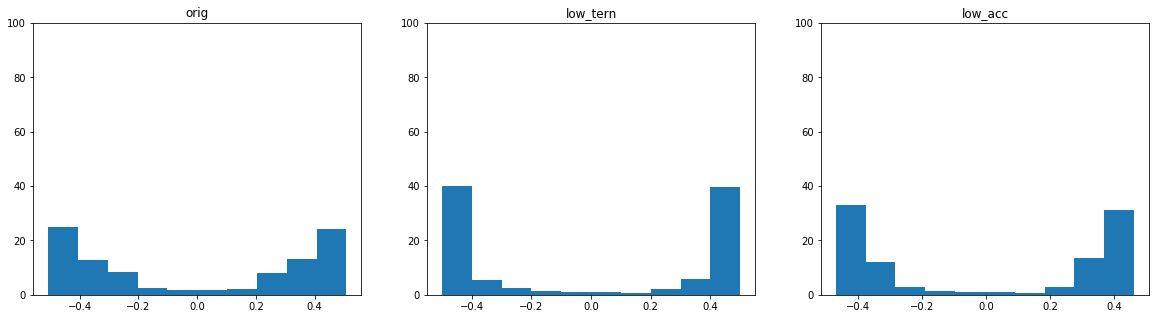

features.4.weight


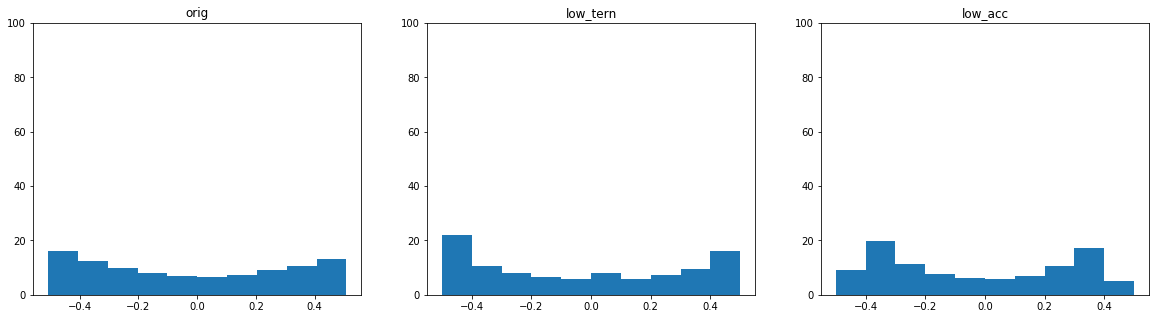

features.8.weight


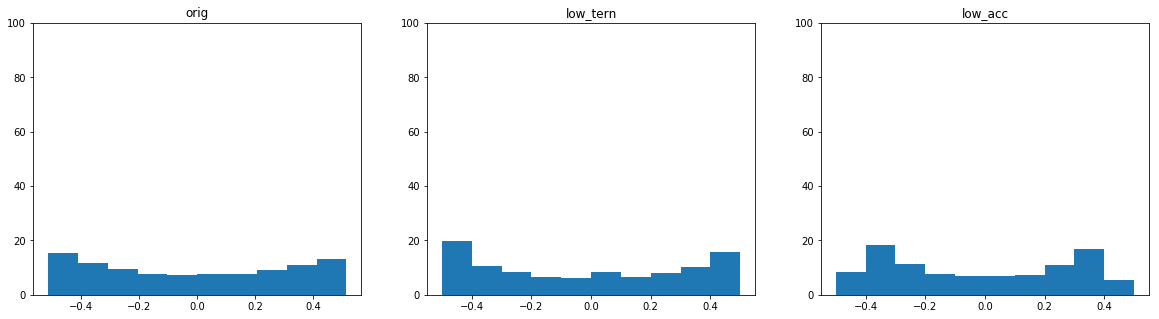

features.11.weight


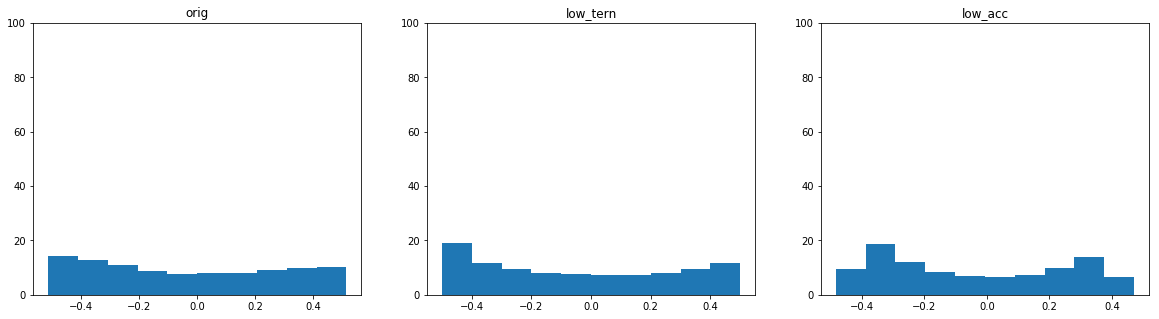

features.15.weight


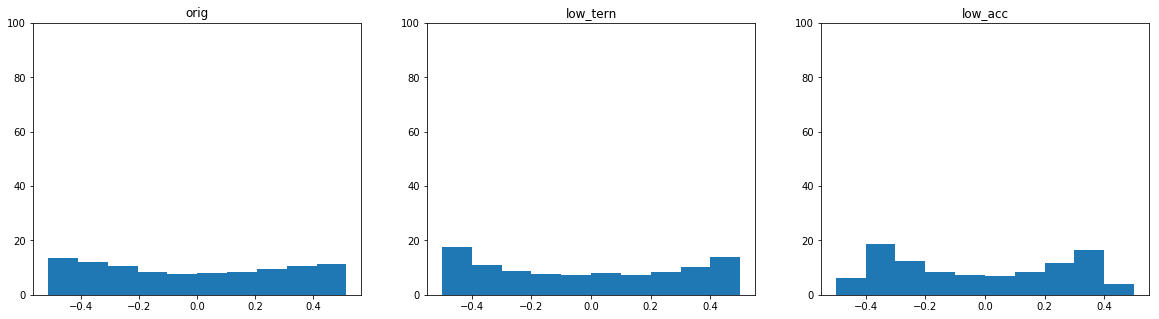

features.18.weight


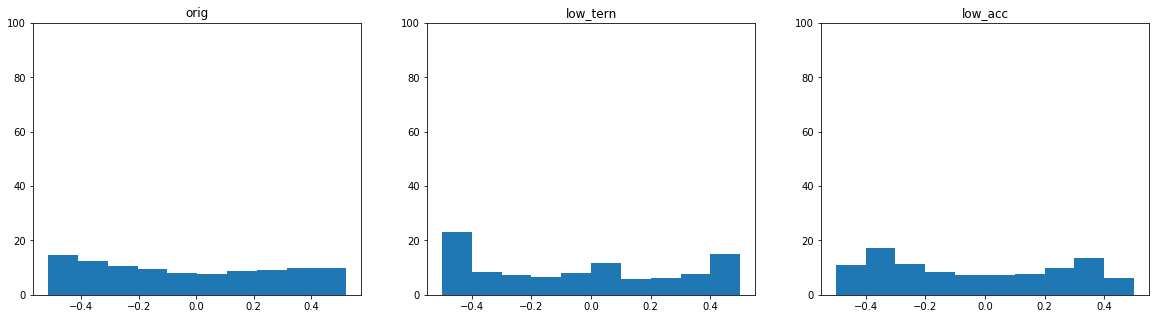

classifier.0.weight


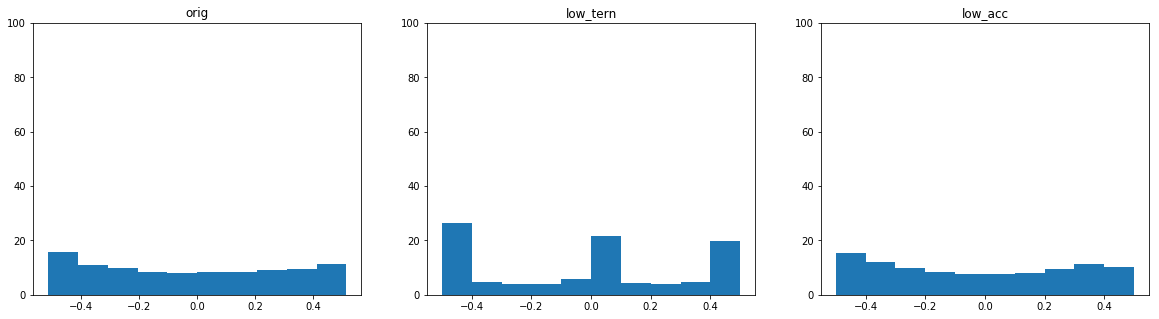

classifier.3.weight


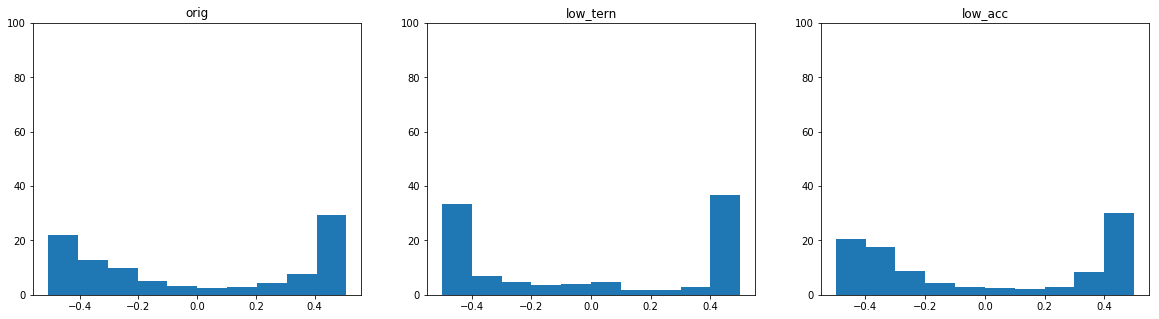

In [4]:
wl = 2
full_tern_bfq = {k:v.cpu().numpy() for k,v in data['full_tern'].items()}
low_tern_bfq = {k:v.cpu().numpy() for k,v in data['low_tern'].items()}
low_acc_bfq = {k:v.cpu().numpy() for k,v in data['low_acc'].items()}
orig_bfq = {k:v.cpu().numpy() for k,v in data['acc_dict'].items()}
layer_keys = orig.keys()
layer_keys, orig['features.1.weight'].shape

def plot_full_hist(k):
    plt.figure(figsize=(20,5))
    for i, (title, wdict) in enumerate([("orig",orig_bfq), ("low_tern",low_tern_bfq), ("low_acc",low_acc_bfq)]):
        plt.subplot(1,3,i+1)
        flat = wdict[k].flatten()
#         plt.hist(flat, density=True, range=(-0.6,0.6))
        plt.hist(flat, density=False, weights=np.ones_like(flat)/float(len(flat))*100.)
        plt.title("%s"%(title))
        plt.ylim(0, 100)
    plt.show()

for k in layer_keys:
    print(k)
    plot_full_hist(k)


In [5]:
from tensorboardX import SummaryWriter
from data_loaders import get_data_loaders
loaders = get_data_loaders('CIFAR10', '.', 0., 128, 4)
writer = SummaryWriter(log_dir="test_run")

def make_model():
    model_cfg = models.WAGEVGG7
    model_cfg.kwargs.update({
        "wl_activate":8, "fl_activate":-1,
        "wl_error": 8, "fl_error":-1,
        "wl_weight":2,
        "layer_type":'wage'
    })
    model = model_cfg.base(
        *model_cfg.args,
        num_classes=10, writer=writer,
        **model_cfg.kwargs) 
    model.cuda()
    return model

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm

model = make_model()
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

quant = lambda name : models.WAGEQuantizer(8, 8, name, writer=None)

def get_network():
    k11 = 'features.1.weight'
    conv11 = nn.Conv2d(3, 128, kernel_size=3, padding=1, bias=False)
    group11 = nn.Sequential(
        models.WAGEQuantizer(8, -1, "input"),
        conv11, nn.ReLU(inplace=True), 
        quant("feature-1-1")
    )
    group11.cuda()
    
    k12 = 'features.4.weight'
    conv12 = nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False)
    group12 = nn.Sequential(
        conv12, nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(inplace=True), quant("feature-1-2")
    )
    group12.cuda()

    k21 = 'features.8.weight'
    conv21 = nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False)
    group21 = nn.Sequential(
        conv21,
        nn.ReLU(inplace=True),
        quant("feature-2-1")
    )
    group21.cuda()
    
    k22 = 'features.11.weight'
    conv22 = nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False)
    group22 = nn.Sequential(
        conv22, nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(inplace=True),
        quant("feature-2-2"),
    )
    group22.cuda()
    
    k31 = 'features.15.weight'
    conv31 = nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False)
    group31 = nn.Sequential(
        conv31, nn.ReLU(inplace=True), quant("feature-3-1")
    )
    group31.cuda()
    
    k32 = 'features.18.weight'
    conv32 = nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False)
    group32 = nn.Sequential(
        conv32, 
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(inplace=True),
        quant("feature-3-2")
    )
    group32.cuda()
    
    kc1 = 'classifier.0.weight'
    lin1 = nn.Linear(8192, 1024, bias=False)
    clf1 = nn.Sequential(
        lin1, nn.ReLU(inplace=True),
        quant("classifier-lin")
    )
    clf1.cuda()
    
    kc2 = 'classifier.3.weight'
    lin2 = nn.Linear(1024, 10, bias=False)
    clf2 = nn.Sequential(
        lin2, models.WAGEQuantizer(-1, 8, "bf-loss")
    )
    clf2.cuda()
    
    groups = {
        k11: group11, k12:group12, 
        k21: group21, k22:group22,
        k31: group31, k32:group32,
        kc1: clf1,    kc2:clf2
    }
    convs  = {
        k11:conv11, k12:conv12, 
        k21:conv21, k22:conv22,
        k31:conv31, k32:conv32,
        kc1:lin1,   kc2:lin2
    }
    keys = [k11, k12, k21, k22, k31, k32, kc1, kc2]
    return groups, convs, keys

def quant_with_thres(w, t_neg, t_pos):
    r = torch.zeros_like(w)
    assert t > 0
    r[w>t_pos] = 0.5
    r[w<-t_neg] = -0.5
    return r

def set_weight(groups, convs, keys, thrs=None, avg_type='full_tern'):
    for k in keys:
        if thrs is not None:
            convs[k].weight.data = quant_with_thres(data[avg_type][k], thrs[k], thrs[k])/model.weight_scale[k]
        else:
            convs[k].weight.data = data[avg_type][k]  / model.weight_scale[k]

def forward(groups,keys,x):
    rets = []
    for k in keys:
        if 'classifier' in k:
            x = x.view(x.size(0),-1)
        x = groups[k](x)
        rets.append(x)
    return rets
            
orig_groups,  orig_convs,  keys  = get_network()
quant_groups, quant_convs, _     = get_network()
print(keys)
set_weight(orig_groups, orig_convs, keys, thrs=None, avg_type='full_tern')


input_thrs = {}
base_lst = []
base_norm_lst = []
with torch.no_grad():
    for k_idx, k in enumerate(keys):
        print(k_idx, k)
        subkeys = keys[:k_idx+1]
        print("Currently searching:\n%s"%str(subkeys))
        errs = []
        cos_errs = []
        thrs = np.arange(0.0, 0.5, 0.01) + 1e-3
        for t in tqdm(thrs):
            input_thrs[k] = t
            set_weight(quant_groups, quant_convs, subkeys, thrs=input_thrs, avg_type='full_tern')
            eacc = 0.
            cos_eacc = 0.
            bnorm = 0.
            ynorm = 0.
            for x,_ in loaders['train']:
                x = x.cuda(async=True)
                b = x.size(0)

                base_res = forward(orig_groups, subkeys, x)
                y_res = forward(quant_groups, subkeys, x)

                base_res      = [x_.view(b,-1) for x_ in base_res]
                base_norm_res = [x_/x_.norm(p=2., dim=1, keepdim=True) for x_ in base_res]

                y_res = [x_.view(b,-1) for x_ in y_res]
                y_norm_res = [x_/x_.norm(p=2., dim=1, keepdim=True) for x_ in y_res]

                eacc += F.mse_loss(y_res[-1], base_res[-1]).cpu().item()
                cos_eacc += (base_norm_res[-1]*y_norm_res[-1]).sum(dim=1,keepdim=False).mean().cpu().item()

            e = eacc / float(len(loaders['train']))
            cos_e = cos_eacc / float(len(loaders['train']))
            errs.append(e)
            cos_errs.append(cos_e)

        min_idx = np.argmin(np.array(errs))
        plt.plot(thrs, errs)
        plt.title("%s:Min Idx:%d Thrs:%s Err:%2.5f"%(k, min_idx, thrs[min_idx], errs[min_idx]))
        plt.ylabel('Error')
        plt.xlabel('Threshold')
        plt.show()

        max_idx = 0
        for i in range(1, len(cos_errs)):
            if cos_errs[i] > cos_errs[max_idx]:
                max_idx = i
        # max_idx = np.argmax(np.array(cos_errs))
        plt.plot(thrs, cos_errs)
        plt.title("%s:Min Idx:%d Thrs:%s CosSim:%2.5f"%(k, max_idx, thrs[max_idx], cos_errs[max_idx]))
        plt.ylabel('Cosine Similarity')
        plt.xlabel('Threshold')
        plt.show()
        
        input_thrs[k] = thrs[min_idx]
        print(input_thrs)

    

['features.1.weight', 'features.4.weight', 'features.8.weight', 'features.11.weight', 'features.15.weight', 'features.18.weight', 'classifier.0.weight', 'classifier.3.weight']
0 features.1.weight
Currently searching:
['features.1.weight']


In [ ]:
# Finall evaluate
import utils
input_thrs = {
    'features.1.weight'  : 0.261,
    'features.4.weight'  : 0.291,
    'features.8.weight'  : 0.301,
    'features.11.weight' : 0.301,
    'features.15.weight' : 0.301,
    'features.18.weight' : 0.301,
    'classifier.0.weight': 0.301,
    'classifier.3.weight': 0.301
}
model = make_model()
model_thr = make_model()

def set_model_weight(model, thrs=None, avg_type='full_tern'):
    for k,p in model.named_parameters():
        if thrs is not None:
            p.data = quant_with_thres(data[avg_type][k], thrs[k], t)/model.weight_scale[k]
        else:
            p.data = data[avg_type][k]/model.weight_scale[k]
            
def eval_model(model):
    for 

set_model_weight(model, thrs=None, avg_type='full_tern')
set_model_weight(model_thr, thrs=input_thrs, avg_type='full_tern')

print('Eval original model:')
orig_res = utils.eval(loaders['test'], model, utils.SSE, wage_quantizer=None)

print('Eval thresholded model:')
thrs_res = utils.eval(loaders['test'], model_thr, utils.SSE, wage_quantizer=None)